<a href="top"></a>
## Contents

* [Setup](#Setup)
* [References](#References)
* [ZDT1](#ZDT1)
* [DTLZ2](#DTLZ2)

## Setup


In [1]:
# Core dependencies
import numpy as np

from anguilla.optimizers.upmocma import UPMOCMA
from anguilla.fitness.base import ObjectiveFunction
from anguilla.fitness import benchmark

In [2]:
# Dependencies for the debug plot
from typing import Any, Optional

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

In [3]:
def contributions_plot(optimizer: UPMOCMA, fn: Optional[ObjectiveFunction]=None, new_point: Optional[np.ndarray]=None) -> Any:
    """Plot the contributions of individuals in the archive."""
    fig = plt.figure(figsize=(12, 6))
    axs = fig.subplots(1, 1)
    # We iterate through the archive to create a list of tuples with the desired data
    # Then, we unzip it into separate lists
    contribs, fitness, step_sizes = list(zip(*[(i.contribution, i.fitness, i.step_size) for i in optimizer._population]))
    contribs = np.array(contribs)
    fitness = np.array(fitness)
    step_sizes = np.array(step_sizes)
    if len(contribs) > 2:
        min_contrib = np.min(contribs[1:-1]) 
        max_contrib = np.max(contribs[1:-1])
    else:
        min_contrib = 0.0
        max_contrib = 0.0
    min_step_size = np.min(step_sizes)
    max_step_size = np.max(step_sizes)
    contribs_cmap = plt.cm.get_cmap("jet", len(contribs) - 2)
    step_size_cmap = plt.cm.get_cmap("viridis", len(step_sizes))
    if fn is not None and fn.has_known_pareto_front:
        front = fn.pareto_front()
        if fn.has_continuous_pareto_front:
            axs.plot(front[0], front[1], color="red", label="True", linestyle="-", zorder=0)
        else:
            axs.plot(front[0], front[1], color="red", label="True", marker=".", linestyle="", zorder=0)
    for i, point in enumerate(fitness):
        step_size_color = step_size_cmap(step_sizes[i] / max_step_size)
        if i == 0 or i == len(fitness) - 1:
            # Exterior points are plotted as stars (they have infinite contribution)
            axs.plot(fitness[i, 0], fitness[i, 1], marker="*", markersize=12,
                     color="black", markerfacecolor=step_size_color, linestyle="", zorder=3)
        else:
            # Interior points are ploted as crosses and their contributions as rectangles
            contrib_color = contribs_cmap(contribs[i] / max_contrib)
            rectangle = Rectangle(fitness[i],
                                  width=fitness[i+1, 0] - fitness[i, 0],
                                  height=fitness[i-1, 1] - fitness[i, 1],
                                  facecolor=contrib_color,
                                  alpha=1.0,
                                  zorder=1)
            axs.add_patch(rectangle)
            axs.plot(fitness[i, 0], fitness[i, 1], marker="+", color=step_size_color, linestyle="", zorder=2)
    if len(contribs) > 2:
        cbar = fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(min_contrib, max_contrib), cmap=contribs_cmap), ax=axs)
        cbar.set_label('Contribution', rotation=270, labelpad=10)
    cbar = fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(min_step_size, max_step_size), cmap=step_size_cmap), ax=axs)
    cbar.set_label('Step size', rotation=270, labelpad=10)
    if new_point is not None:
        axs.plot(new_point[0], new_point[1], color="green", label="New point", marker="P", zorder=4)
    axs.legend()
    axs.set_title("{} (pop. size {}, {} func. evaluations)".format(
        optimizer.qualified_name,
        optimizer._population.size,
        optimizer.evaluation_count))
    axs.set_xlabel("First objective")
    axs.set_ylabel("Second objective")
    fig.tight_layout()
    return fig

In [4]:
rng_base = np.random.default_rng()
#seed = rng_base.integers(1, 75458458, size=1)[0]
seed = 43724437
print("Seed: ", seed)

Seed:  43724437


In [5]:
def run_and_plot(fn_cls, seed, plot_at=[]):
    if not plot_at:
        plot_at = [0]
    rng = np.random.default_rng(5456)
    D = 10
    fn = fn_cls(D, rng=rng)
    initial_points = fn.random_points(D)
    initial_fitness = fn(initial_points)
    optimizer = UPMOCMA(initial_points, initial_fitness, rng=rng, max_evaluations=max(plot_at))
    fig = contributions_plot(optimizer, fn=fn)
    while not optimizer.stop.triggered:
        point = optimizer.ask()
        if fn.has_constraints:
            _, penalized_fitness = fn.evaluate_with_penalty(point)
            optimizer.tell(penalized_fitness)
        else:
            fitness = fn(point)
            optimizer.tell(fitness)
        if optimizer.evaluation_count in plot_at:
            fig = contributions_plot(optimizer, fn=fn)
    return fig

## ZDT1

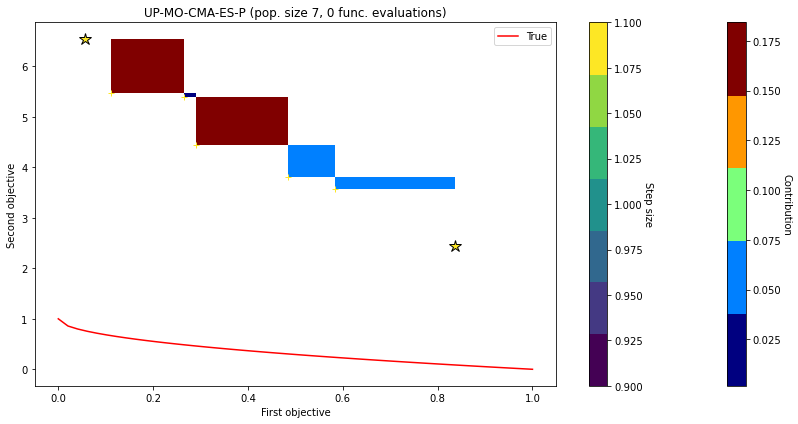

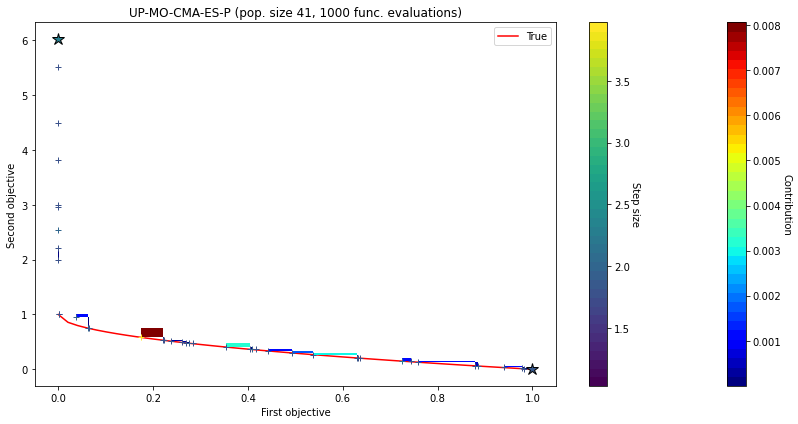

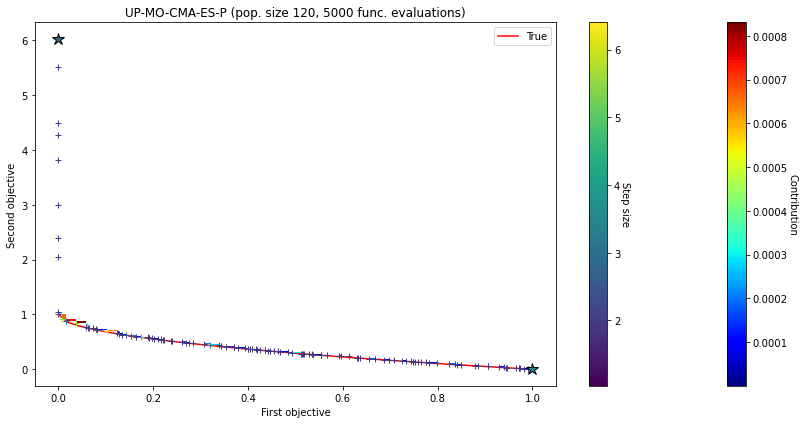

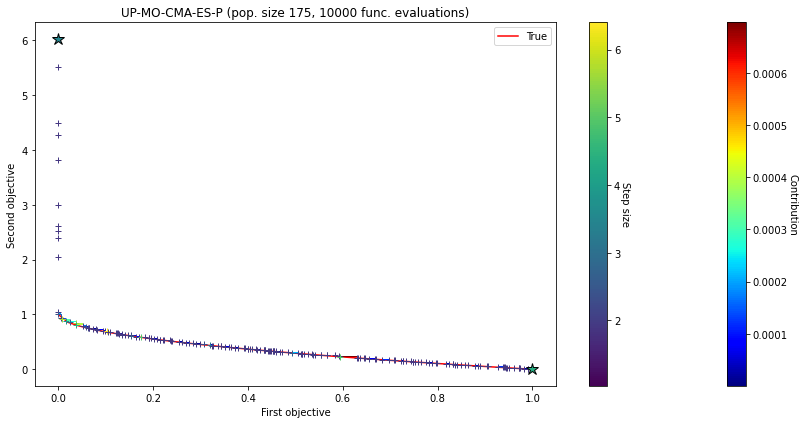

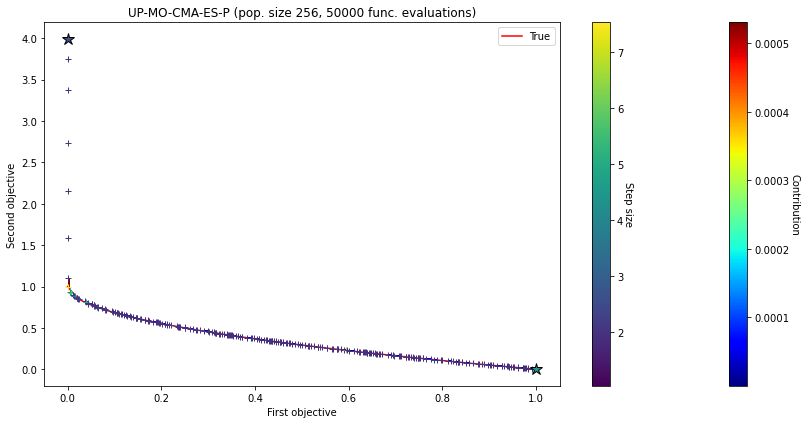

In [6]:
fig = run_and_plot(benchmark.ZDT1, seed, plot_at=[1000, 5000, 10000, 50000])

## DTLZ2

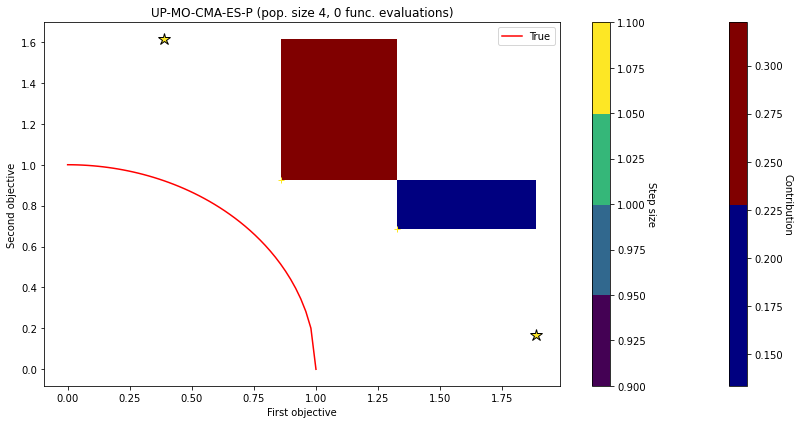

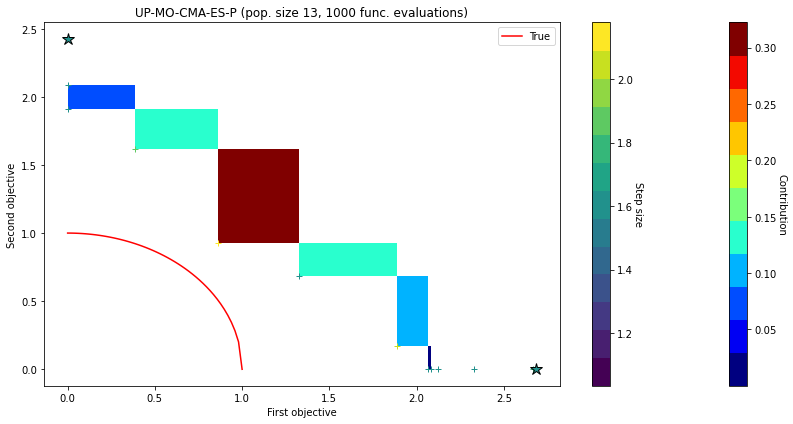

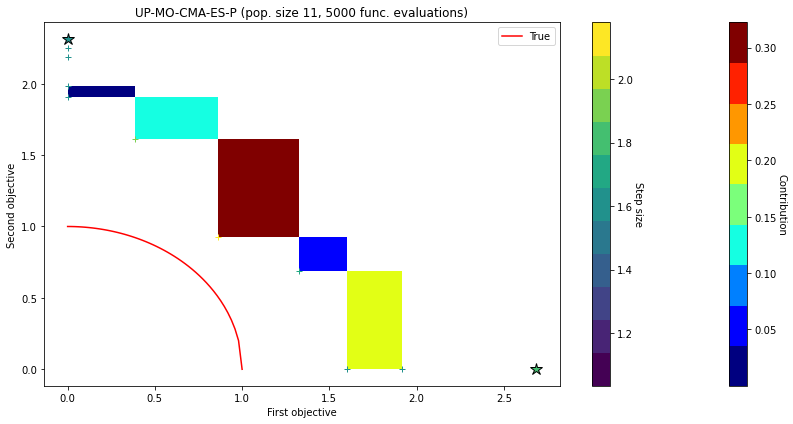

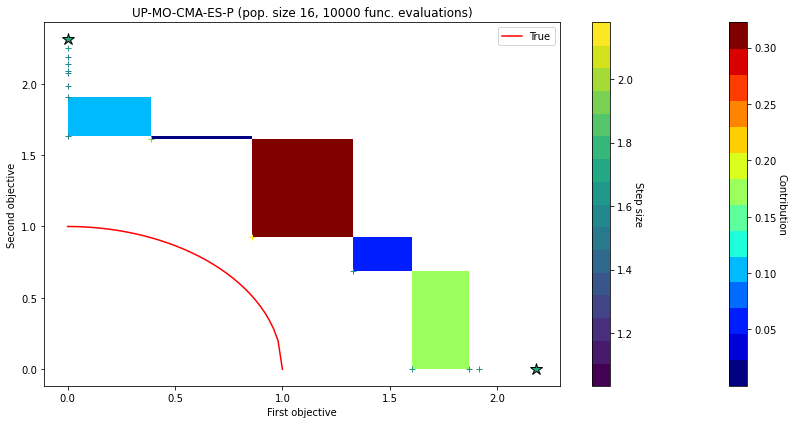

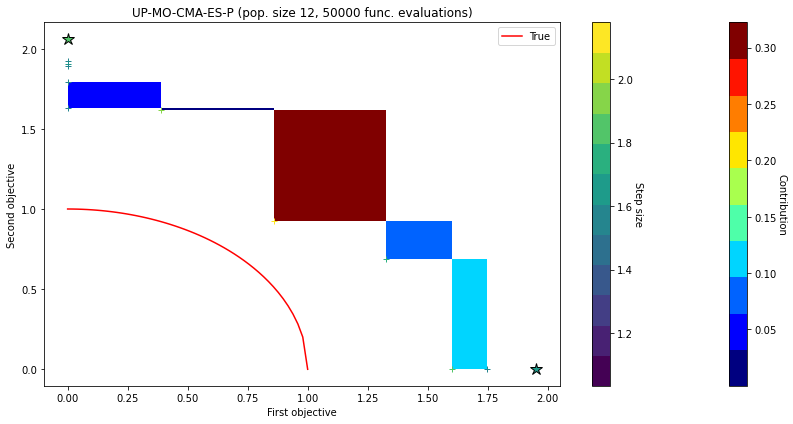

In [7]:
fig = run_and_plot(benchmark.DTLZ2, seed, plot_at=[1000, 5000, 10000, 50000])

## References

[1] O. Krause, T. Glasmachers, N. Hansen, and C. Igel. Unbounded Population MO-CMA-ES for the Bi-Objective BBOB Test Suite. In GECCO’16 - Companion of Proceedings of the 2016 Genetic and Evolutionary Computation Conference, 1177–1184. Denver, United States, July 2016. ACM. URL: https://hal.inria.fr/hal-01381653, doi:10.1145/2908961.2931699.